## TODO 

#### general: 

* General Analysis
* ~Try different Sentiment Analysis Tools~
* Restructure Notebook
* ~Skip whole cells on parameter~



#### Mittwoch

* ~Start report~
* ~Write Method section~
* ~Introduction~
* ~Check current dataset - especially with first day in before timespan~
* ~Try different sentimet analysis tools~
* ~30 min research about alternatives~
* Ideas about general Analysis tools
* ~Generierung der Datensätze~

# Data Literacy Student Project

### Main Question : Has the amount of transphobic tweets increased under Elon Musk?



This notebook was created as part of the team project for the Data Literacy course. The code for the data analysis project has been carried out in this jupyter notebook and is the work of 

    Fabian Köninger  4200890   fabian.koeninger@student.uni-tuebingen.de
    Markus Deppner   4106780   markus.deppner@student.uni-tuebingen.de
    
This project tackles the question if the amount of transphobic tweets has increased since the takeover of Twitter by Elon Musk. 
The background to this projecte idea aroused by Elon Musks 44 billion USD takeover of twitter on 27th of October 2022. 
One day after the takeover, on 28th of October 20222, Musk tweeted that "Anyone suspended for minor & dubious reasons will be freed from Twitter jail". Musk describes himself as an "absolutist of free speach", which lead to LGBTQ people that fear the harrassment they might face after the takeover. 

This notebook ist designed in the following structure:

### Outline

* [1. Setup](#setup_section)
* [2. Authentification](#authentification_section)
* [3. Composition of Dataset](#crawling_section)
* [4. General Data Anaylsis](#general_analysis)
* [5. Sentiment Analysis](#sentiment_analysis)
* [6. Wordcloud](#wordcloud)

### <a name="setup_section"></a> 1. Setup: Manage Installations Imports and Helper Functions

In [210]:
# Installations
# Comment out the following line in case you have not already included any of the following libraries 
# that are required for this notebook in your setup 

#!pip install tweepy
#!pip install textblob
#!python -m textblob.download_corpora
#!pip install wordcloud
#!pip install -q transformers
#!pip install tensorflow
#!pip install torch
#!pip3 install emoji==0.6.0
#!pip install vaderSentiment
#!pip install hatesonar

#Imports
import tweepy
import json
import datetime 
import os
import pandas as pd
import csv
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import tensorflow
import re
import sklearn.linear_model 


from datetime import date, datetime, timedelta 
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from statistics import mean
from transformers import pipeline
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from hatesonar import Sonar
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from scipy.stats import norm
from scipy.stats import shapiro
from scipy.stats import ttest_ind
from scipy.stats import wilcoxon

In [2]:
# Found in this thread: https://stackoverflow.com/questions/26494747/simple-way-to-choose-which-cells-to-run-in-ipython-notebook-during-run-all
# This allows us to specifiy a parameter to skip cells when running the whole notebook

def skip(line, cell=None):
    '''Skips execution of the current line/cell if line evaluates to True.'''
    if eval(line):
        return

    get_ipython().ex(cell)

def load_ipython_extension(shell):
    '''Registers the skip magic when the extension loads.'''
    shell.register_magic_function(skip, 'line_cell')
    
load_ipython_extension(get_ipython())

In [3]:
# A parameter that needs to be set to true, to enable the crawling of tweets
# When changing this variable, you enable the request section actually requests will be sent to Twitters API and the results 
# will be stored in the file which you specified as fileName
compose_dataset = False

###  <a name="authentification_section"></a> 2. Authentifaction: Set Credentials to access the Twitter API

In [4]:
# Think of the API key as the user name that represents your App when making API requests. It helps us verify who you are.
# api_key = 'ejMMb5Cvj2d6s0gwDAJi3Y9Cc'  

# Your API Key Secret is like a password and helps verify your API Key. This will be one of the last times you'll see it displayed, so remember to save it in a safe place.
# api_key_secret= 'RNZEFHl3PAtQkxpZTC1YliGbfcSdjlL4SnuX6fnR1PWJ1xDbGW'

# An Access Token used in authentication that allows you to pull specific data.
bearer_token = 'AAAAAAAAAAAAAAAAAAAAAIUAkwEAAAAAyQuxM73RN3fkHhDCy%2BConF0mzjg%3DIK6iouUoVLUcseqcoSOYs3wZYSRfsrlzXsfRO2ac5uk6EYTQX7'

os.environ['Twitter_Bearer_Token'] = bearer_token

In [5]:
def auth():
    return os.getenv('Twitter_Bearer_Token')

In [6]:
consumer_key = 'ejMMb5Cvj2d6s0gwDAJi3Y9Cc'
consumer_secret = 'RNZEFHl3PAtQkxpZTC1YliGbfcSdjlL4SnuX6fnR1PWJ1xDbGW'
access_token = '1600184977420963845-iCZd2SeMRDtUusQOJofjNDYtJadGNB'
access_secret = 'TFwzBo8ZzppEWfQX5n0Dq1jWhT9eHEjpu53tpjnOh5MCC'

client = tweepy.Client(
    bearer_token = auth(),
    consumer_key = consumer_key,
    consumer_secret = consumer_secret,
    access_token = access_token,
    access_token_secret = access_secret
)

###  <a name="crawling_section"></a> 3. Composition of Dataset

In this section we build and send the requests to Twitters API in order to retrieve and build our dataset for the analysis.
We want to get all the tweets during the timespam from 01.01.2022 to 31.12.2022 in order to cover a whole year and get a sufficient timespan before and after Elon Musks takeover. 

We crawl all tweets that contain specified keywords in their message and were created during our defined timespan. 

### Helper functions

In [7]:
"""
This function processes a response from Twitters API and converts it into a row that can be saved into our csv file. 
This funcrtion first opens or creates the name with the given filename, for each tweet extracts the information from the response
and appends this converted result in the csv later on. 


@ params  tweets: as a response from Twitters API
          fileName: name of the file to be created or opened
"""
def append_to_csv(tweets, fileName):

    #A counter variable
    counter = 0

    #Open or create the target CSV file
    csvFile = open(fileName, "a", newline="", encoding='utf-8')
    csvWriter = csv.writer(csvFile)

    #Loop through each tweet
    for tweet in tweets.data:
        
        # We will create a variable for each entry since some of the keys might not exist for some tweets
        # So we will account for that
        
        # Tweet Fields
    
        # 1. ID
        tweet_id = tweet['id']
        
        # 2. Text 
        text = tweet['text']
        
        # 3. Author ID
        author_id = tweet['author_id']

        # 4. Time created
        created_at = tweet['created_at']

        # 5. Conversation ID
        conversation_id = tweet['conversation_id']
        
        # 6. Entities
        entities = tweet['entities']
        
        # 7. In reply to User Id
        reply_to_user = tweet['in_reply_to_user_id']
        
        # 8. Language
        lang = tweet['lang']
        
        # 9. Possibly Sensitive
        possibly_sensitive = tweet['possibly_sensitive']
                  
        # 10. Tweet metrics
        retweet_count = tweet.public_metrics['retweet_count']    
        reply_count = tweet.public_metrics['reply_count']
        like_count = tweet.public_metrics['like_count']
        quote_count = tweet.public_metrics['quote_count']
        
    
        # Place Fields
        
        places_extension = tweets.includes['places'] if 'places' in tweets.includes else []
        
        # 11. Place ID
        if 'geo' in tweet:
            place_id = tweet.geo['place_id']
        else:
            place_id = None
        
        # 12. Place Name
        if 'geo' in tweet:
            place_id = tweet.geo['place_id']
            place = [place for place in places_extension if place.id == place_id ][0]
            place_name = place.full_name
        else: 
            place_name = None
        
        
        # User Fields  
        
        users_extension = tweets.includes['users'] if 'users' in tweets.includes else []
        
        # 13. Name of User
        if 'author_id' in tweet: 
            user_full_name = [user.name for user in users_extension if user.id == author_id ][0]
        else: 
            user_full_name = None
            
        # 14. Username
        if 'author_id' in tweet: 
            username = [user.username for user in tweets.includes['users'] if user.id == author_id ][0]
        else: 
            username = None
            
        
        # Assemble all data in a list 
        res = [tweet_id, 
               text, 
               author_id, 
               created_at, 
               conversation_id, 
               entities, 
               reply_to_user, 
               lang, 
               possibly_sensitive,
               retweet_count,
               reply_count,
               like_count, 
               quote_count, 
               place_id, 
               place_name,
               user_full_name, 
               username]
        
        # Append the result to the CSV file
        csvWriter.writerow(res)
        counter += 1

    # When done, close the CSV file
    csvFile.close()

    # Print the number of tweets for this iteration
    print("# of Tweets added from this response: ", counter) 

In [8]:
def days_in_between(startdate, enddate):
    startdates = []
    enddates   = []
    while startdate < enddate:
        startdates.append(startdate)
        startdate += timedelta(days=1)
        enddates.append(startdate)
    return startdates, enddates

### Request Section 

Our dataset 

Step 1:  Open a file in which the data is stored

Step 2: Define the request parameteres to start the request

Step 3: Iterate through the responses until all data that contain our keywords in the give timespan are crawled 

### Step 1 Specify all parameters

In [9]:
# Specify start and end dates for the timeperiod before and after the takeover
# The timespan is defined such that we take the days from a present date up to the date of when the acquistion was completed.
# From that day of the acquisition we go the same timespan back in time such that we obtain equally large parts of the time
# before and after the takover.

date_of_acquisition = datetime(2022,10,27,0,0,0)

# Timespan after the acquisition
enddate_after = datetime(2023,1,21,0,0,0)
startdate_after = date_of_acquisition

# Timespan before the acquisition
difference_in_days = (enddate_after - date_of_acquisition).days
startdate_before = date_of_acquisition - timedelta(days = difference_in_days)
enddate_before   = date_of_acquisition 

startdates_after, enddates_after   = days_in_between(startdate_after, enddate_after)
startdates_before, enddates_before = days_in_between(startdate_before, enddate_before)
startdates_all, enddates_all       = days_in_between(startdate_before, enddate_after) 

In [10]:
# Setup parameters for request

keywords     = '(LGBTQ OR LGBTQI OR "LGBTQI+" OR "LGBTQIA+" OR "LGBTQIA*" OR trans OR queer OR gay OR lesbian OR bisexual OR 🌈 OR LesBiGay OR homo OR tranny OR trannie) -"RT"'
query        = keywords + ' -is:retweet lang:en'
tweet_fields = 'id,text,author_id,created_at,conversation_id,entities,in_reply_to_user_id,lang,possibly_sensitive,public_metrics'
expansions   = 'geo.place_id,author_id'
place_fields = 'id,full_name,country,geo'
user_fields  = 'id,name,username,description'

# Parameters for looping requests
max_results_per_request = 500 
max_limit_per_day       = 6000
tweet_count             = 0

fileName     = 'data_global.csv'



### Step 2 Create a csv file with header in which the data is saved

In [11]:
%%skip not compose_dataset # This cell is skipped by default if the parameter to compse the dataset is not set to True
 

# Create or open file
csvFile = open(fileName, "a", newline="", encoding='utf-8')
csvWriter = csv.writer(csvFile)

# Create a header in the csv for the data we want to save
csvWriter.writerow(['id', 
                    'text', 
                    'author_id',
                    'created_at', 
                    'conversation_id', 
                    'entities', 
                    'in_reply_to_user_id',
                    'lang', 
                    'possibly_sensitive',
                    'retweet_count', 
                    'reply_count', 
                    'like_count', 
                    'quote_count', 
                    'place_id', 
                    'place_name',
                    'user_full_name', 
                    'username'])
csvFile.close()


### Step 3 Send multiple requests to compose dataset

In [12]:
%%skip not compose_dataset # This cell is skipped by default if the parameter to compse the dataset is not set to True


for startdate,  enddate in zip(startdates_all, enddates_all):
    time.sleep(15)
    flag = True
    next_token  = None
    tweet_count = 0
    iteration   = 0
    print("-------------------")
    print("Start date: " + str(startdate))


    while flag: 
        if tweet_count >= max_limit_per_day:
            break


        print("-------------------")
        print("Iteration: " + str(iteration))
        print("Token: ", next_token)

        # Perform initial request on Twitters API 
        tweets = client.search_all_tweets(
            query=query, 
            start_time=startdate, 
            end_time=enddate, 
            tweet_fields = tweet_fields,
            expansions = expansions,
            place_fields = place_fields,
            user_fields = user_fields,
            max_results = max_results_per_request,
            next_token = next_token
        )

        result_count = tweets.meta['result_count']

        if('next_token' in tweets.meta):
            # Save the token to use for next call       
            next_token = tweets.meta['next_token']
            print("Next Token: ", next_token)
            if(result_count is not None and result_count > 0 and next_token is not None):
                append_to_csv(tweets, fileName)
                iteration += 1
                tweet_count += result_count
                print("Total # of Tweets added: ", tweet_count)
                print("-------------------")
                time.sleep(10)  

        # If no next token exists
        else: 
            if result_count is not None and result_count > 0:
                print("-------------------")
                append_to_csv(tweets, fileName)
                tweet_count += result_count
                print("Total # of Tweets added: ", tweet_count)
                print("-------------------")
                time.sleep(10)
                

            flag = False
            next_token = None
            time.sleep(10)
    print("Total number of results: ", tweet_count)

###  <a name="general_analysis"></a> 4. General Analysis


### Interesting metrics

* Who was the user that posted the most
* From where do most of the tweets come from? location wise?


#### Load the previously created dataset

In [13]:
df = pd.read_csv('data.csv') # TODO change to fileName

# Cast the column 'created_at' which stores the timestamp of the tweet to a datetime object 
# such that we can easily compare and filter our dataset by dates 
df['created_at'] = pd.to_datetime(df.created_at).dt.tz_localize(None)

### Clean the dataset and preprocess the data

In [14]:
def process_tweet_text(tweet):
    tweet = re.sub(r'http\S+', '', tweet)
    tweet = re.sub(r'@\S+', '', tweet)
    tweet = tweet.replace('\n', ' ')
    tweet = tweet.replace('#', '')
    tweet = tweet.replace('\xa0', ' ')
    return tweet


In [15]:
# Function found on https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python
# and andjusted to some extra emojis that were not yet covered

def remove_emojis(text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\u23F0"
        u"\ufe0f"  # dingbats
        u"\u3030"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [16]:
# Create new dataframe that will hold processed data and the results of our analysis
df_processed = df[['id', 'text', 'created_at']].copy()

# Process each tweet text such that we remove all links, username references with @username, linebreaks \n, Hashtags #, and \xa0
original_text = df_processed['text'].copy()
original_text_array = original_text.to_numpy()
processed_text = [process_tweet_text(tweet) for tweet in original_text_array]

# Add column 'processed_text' to dataframe which contains the cleaned text with out links, user-references, hashtags etc. 
df_processed = df_processed.assign(processed_text=processed_text)


# Remove all emojis from the already processed text 
processed_no_emojis = [remove_emojis(text) for text in processed_text]

# Add column 'processed_text_no_emojis' that contains the cleaned text without emojis
df_processed = df_processed.assign(processed_text_no_emojis=processed_no_emojis)

### <a name="sentiment_analysis"></a> 5. Sentitment analysis

### TextBlob library

In [146]:
# Iterate over the whole dataset and compute the polarity and subjectivity of the individual tweets
avg_polar = 0.
avg_subj = 0.
count = 0
polarities = np.zeros(df.shape[0])
subjectivities = np.zeros(df.shape[0])

for index, tweet in df_processed.iterrows():
    text = tweet['processed_text_no_emojis']
    blob = TextBlob(text)
    count+=1

    polar = blob.sentiment[0]    # Polarity between -1, 1
    subj = blob.sentiment[1]     # Subjectivity
    polarities[index] = polar
    subjectivities[index] = subj
    
    avg_polar +=polar
    avg_subj +=subj
   
    
print("Number of tweets analysed: ", count)
print("Average polarity: ", avg_polar/count)
print("Average subjectivity: ", avg_subj/count)

Number of tweets analysed:  217011
Average polarity:  0.1871630874383054
Average subjectivity:  0.4736726408447406


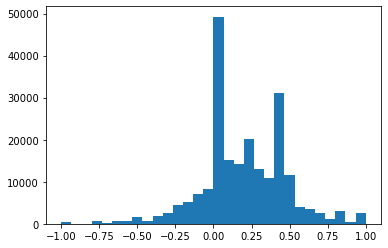

In [149]:
pol_values, pol_bins, _ = plt.hist(polarities, bins=30)

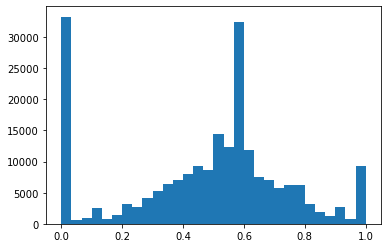

In [150]:
subj_values, subj_bins, _ = plt.hist(subjectivities, bins=30)

In [155]:
polarities_per_day = []
subjectivity_per_day = []


for startdate, enddate in zip(startdates_all, enddates_all):
    df_temp = df_processed.loc[(df_processed['created_at'] >= startdate) & (df_processed['created_at'] < enddate)]
    if df_temp.size != 0:

        polarities = []
        subjectivities = []
        count = 0
        for index, tweet in df_temp.iterrows():
            text = tweet['processed_text_no_emojis']
            blob = TextBlob(text)

            polar = blob.sentiment[0]    # Polarity between -1, 1
            subj = blob.sentiment[1]     # Subjectivity
            polarities.append(polar)
            subjectivities.append(subj)
            count += 1

        print("Day: " + str(startdate))
        print("Number of tweets analysed: ", count)
        print("Average polarity: ", mean(polarities))
        print("Average subjectivity: ", mean(subjectivities))
        print("*********************************************")


        polarities_per_day.append(mean(polarities))
        subjectivity_per_day.append(mean(subjectivities))
    else:
        polarities_per_day.append(np.nan)
        subjectivity_per_day.append(np.nan)

        
polarities_per_day = np.array(polarities_per_day)
subjectivity_per_day = np.array(subjectivity_per_day)

Day: 2022-08-02 00:00:00
Number of tweets analysed:  1028
Average polarity:  0.18645587745298522
Average subjectivity:  0.4684261205569311
*********************************************
Day: 2022-08-03 00:00:00
Number of tweets analysed:  2104
Average polarity:  0.1928972769684579
Average subjectivity:  0.4568147726700568
*********************************************
Day: 2022-08-04 00:00:00
Number of tweets analysed:  2114
Average polarity:  0.18910607279976405
Average subjectivity:  0.4655583132372226
*********************************************
Day: 2022-08-05 00:00:00
Number of tweets analysed:  2432
Average polarity:  0.1801200006232579
Average subjectivity:  0.4505121117259716
*********************************************
Day: 2022-08-06 00:00:00
Number of tweets analysed:  2060
Average polarity:  0.18646011038558796
Average subjectivity:  0.4588412280321261
*********************************************
Day: 2022-08-07 00:00:00
Number of tweets analysed:  2110
Average polarity:  

Day: 2022-09-16 00:00:00
Number of tweets analysed:  1198
Average polarity:  0.19368114179236792
Average subjectivity:  0.47858148793718497
*********************************************
Day: 2022-09-17 00:00:00
Number of tweets analysed:  1069
Average polarity:  0.18164429200430765
Average subjectivity:  0.47128413463185614
*********************************************
Day: 2022-09-18 00:00:00
Number of tweets analysed:  1056
Average polarity:  0.19122633857554822
Average subjectivity:  0.46907410912961117
*********************************************
Day: 2022-09-19 00:00:00
Number of tweets analysed:  1114
Average polarity:  0.19554744575748972
Average subjectivity:  0.48702628129341713
*********************************************
Day: 2022-09-20 00:00:00
Number of tweets analysed:  1241
Average polarity:  0.2109265751375623
Average subjectivity:  0.4661738849114382
*********************************************
Day: 2022-09-21 00:00:00
Number of tweets analysed:  1167
Average polari

Day: 2022-10-31 00:00:00
Number of tweets analysed:  1327
Average polarity:  0.1901537622903969
Average subjectivity:  0.4937619246919786
*********************************************
Day: 2022-11-01 00:00:00
Number of tweets analysed:  1380
Average polarity:  0.17102379815469473
Average subjectivity:  0.47357410690490404
*********************************************
Day: 2022-11-02 00:00:00
Number of tweets analysed:  1226
Average polarity:  0.17462917426969504
Average subjectivity:  0.4561129776588586
*********************************************
Day: 2022-11-03 00:00:00
Number of tweets analysed:  1199
Average polarity:  0.16907948678806192
Average subjectivity:  0.46118966190265437
*********************************************
Day: 2022-11-04 00:00:00
Number of tweets analysed:  1297
Average polarity:  0.18851735446132975
Average subjectivity:  0.45725958734455907
*********************************************
Day: 2022-11-05 00:00:00
Number of tweets analysed:  1217
Average polarit

Day: 2022-12-15 00:00:00
Number of tweets analysed:  1228
Average polarity:  0.18508209080860263
Average subjectivity:  0.48192797566402057
*********************************************
Day: 2022-12-16 00:00:00
Number of tweets analysed:  1064
Average polarity:  0.1818501734449388
Average subjectivity:  0.4576968849528262
*********************************************
Day: 2022-12-17 00:00:00
Number of tweets analysed:  978
Average polarity:  0.17203918675000443
Average subjectivity:  0.47588633846434025
*********************************************
Day: 2022-12-18 00:00:00
Number of tweets analysed:  1045
Average polarity:  0.19102239681299313
Average subjectivity:  0.4692980047965039
*********************************************
Day: 2022-12-19 00:00:00
Number of tweets analysed:  947
Average polarity:  0.1901297148246729
Average subjectivity:  0.47310452258725
*********************************************
Day: 2022-12-20 00:00:00
Number of tweets analysed:  1067
Average polarity:  0.

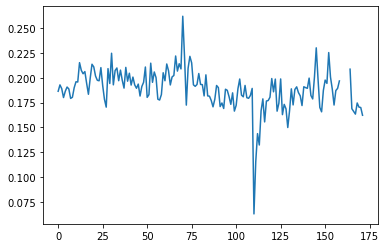

In [156]:
polarities_per_day = np.array(polarities_per_day)
polarities_per_day[polarities_per_day == 0] = np.nan
plt.plot(polarities_per_day)

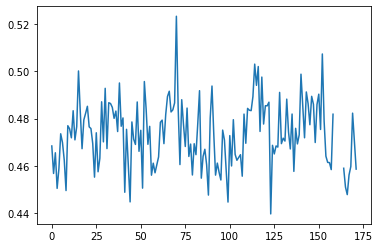

In [157]:
subjectivity_per_day = np.array(subjectivity_per_day)
subjectivity_per_day[subjectivity_per_day == 0] = np.nan
plt.plot(subjectivity_per_day)

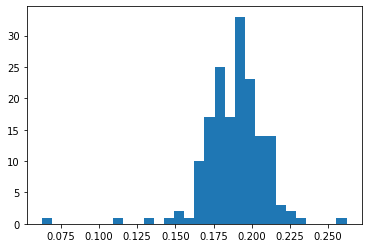

In [158]:
values_pol, bins_pol, _ = plt.hist(polarities_per_day, bins=30)

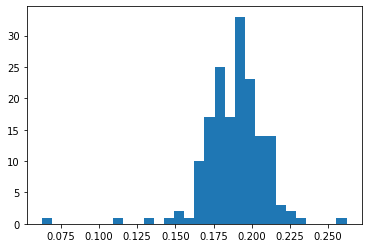

In [159]:
values_subj, bins_subj, _ = plt.hist(polarities_per_day, bins=30)

### HuggingFace Sentiment Analysis Library

In [160]:
sentiment_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [161]:
tweets_text = df_processed['processed_text_no_emojis'].to_numpy()

In [165]:
# Iterate over the whole dataset and compute the polarity and subjectivity of the individual tweets
sentiment_dict = sentiment_pipeline(tweets_text.tolist()[:200])

In [166]:
sentiment_dict

[{'label': 'POSITIVE', 'score': 0.9995747208595276},
 {'label': 'NEGATIVE', 'score': 0.9764809608459473},
 {'label': 'NEGATIVE', 'score': 0.9756335020065308},
 {'label': 'NEGATIVE', 'score': 0.9969738721847534},
 {'label': 'POSITIVE', 'score': 0.7831735610961914},
 {'label': 'NEGATIVE', 'score': 0.9920108914375305},
 {'label': 'NEGATIVE', 'score': 0.9987772107124329},
 {'label': 'NEGATIVE', 'score': 0.9996341466903687},
 {'label': 'NEGATIVE', 'score': 0.9296422004699707},
 {'label': 'NEGATIVE', 'score': 0.9901907444000244},
 {'label': 'POSITIVE', 'score': 0.9996601343154907},
 {'label': 'NEGATIVE', 'score': 0.9281166791915894},
 {'label': 'NEGATIVE', 'score': 0.977348804473877},
 {'label': 'NEGATIVE', 'score': 0.9991292357444763},
 {'label': 'NEGATIVE', 'score': 0.9818103313446045},
 {'label': 'NEGATIVE', 'score': 0.9992227554321289},
 {'label': 'POSITIVE', 'score': 0.9998694658279419},
 {'label': 'NEGATIVE', 'score': 0.9905807375907898},
 {'label': 'NEGATIVE', 'score': 0.9783579111099

### HuggingFace Sentiment Analysis Library - Twitter Model

In [32]:
tweets_text = df_processed['processed_text_no_emojis'].to_numpy()

In [167]:
specific_model = pipeline(model="finiteautomata/bertweet-base-sentiment-analysis")
sentiment_dict_tweet_model = specific_model(tweets_text.tolist()[:20])

In [168]:
sentiment_dict_tweet_model

[{'label': 'POS', 'score': 0.5486928224563599},
 {'label': 'NEG', 'score': 0.8963361978530884},
 {'label': 'NEG', 'score': 0.8284400105476379},
 {'label': 'NEG', 'score': 0.9705238342285156},
 {'label': 'NEU', 'score': 0.9579043388366699},
 {'label': 'NEU', 'score': 0.7766282558441162},
 {'label': 'NEG', 'score': 0.9772082567214966},
 {'label': 'NEG', 'score': 0.6388963460922241},
 {'label': 'NEG', 'score': 0.9252501130104065},
 {'label': 'NEU', 'score': 0.952489972114563},
 {'label': 'NEU', 'score': 0.8737789988517761},
 {'label': 'NEU', 'score': 0.7114633321762085},
 {'label': 'NEU', 'score': 0.8639077544212341},
 {'label': 'NEU', 'score': 0.9470519423484802},
 {'label': 'NEU', 'score': 0.832317054271698},
 {'label': 'NEG', 'score': 0.951788067817688},
 {'label': 'POS', 'score': 0.9906414151191711},
 {'label': 'NEU', 'score': 0.962438702583313},
 {'label': 'NEG', 'score': 0.7383421063423157},
 {'label': 'NEU', 'score': 0.9164910912513733}]

### Vader Sentiment Analysis

In [17]:
tweets_text_clean = df_processed['processed_text_no_emojis'].to_numpy()

In [18]:
vader_sentiment_analyzer = SentimentIntensityAnalyzer()

sentiment_list = []
for tweet in tweets_text_clean:
    sentiment_dict = vader_sentiment_analyzer.polarity_scores(tweet)
    sentiment_list.append(sentiment_dict)

In [28]:
# Extract values from the dictionaries
negative_values = np.zeros(len(sentiment_list))
positive_values = np.zeros(len(sentiment_list))
neutral_values = np.zeros(len(sentiment_list))
compound_values = np.zeros(len(sentiment_list))
labels = np.empty(len(sentiment_list), dtype='<U20')

for index, sent_dict in enumerate(sentiment_list): 
    negative_values[index] = sent_dict['neg']
    positive_values[index] = sent_dict['pos']
    neutral_values[index] = sent_dict['neu']
    compound_values[index] = sent_dict['compound']
    
    if sent_dict['compound'] >= 0.05 :
        labels[index] = "Positive"
 
    elif sent_dict['compound'] <= -0.05 :
        labels[index] = "Negative"
 
    else :
        labels[index] = "Neutral"

    

In [29]:
# Create new columns in the processed datframe for the results of the VADER sentiment analysis 
df_processed = df_processed.assign(vader_positive = positive_values)
df_processed = df_processed.assign(vader_negative = negative_values)
df_processed = df_processed.assign(vader_neutral = neutral_values)
df_processed = df_processed.assign(vader_compound = compound_values)
df_processed = df_processed.assign(vader_label = labels)

In [31]:
positive_per_day = np.zeros(len(startdates_all))
negative_per_day = np.zeros(len(startdates_all))
neutral_per_day  = np.zeros(len(startdates_all))
index = 0

for startdate, enddate in zip(startdates_all, enddates_all):
    df_temp = df_processed.loc[(df_processed['created_at'] >= startdate) & (df_processed['created_at'] < enddate)]
    if df_temp.size != 0:
        
        positive_count_of_day = df_temp.loc[df_temp['vader_label'] == 'Positive'].count()['vader_label']
        negative_count_of_day = df_temp.loc[df_temp['vader_label'] == 'Negative'].count()['vader_label']
        neutral_count_of_day = df_temp.loc[df_temp['vader_label'] == 'Neutral'].count()['vader_label']

        
        positive_per_day[index] = positive_count_of_day
        negative_per_day[index] = negative_count_of_day
        neutral_per_day[index]  = neutral_count_of_day
        
    else:
        positive_per_day[index] = np.nan
        negative_per_day[index] = np.nan
        neutral_per_day[index]  = np.nan
    
    index += 1


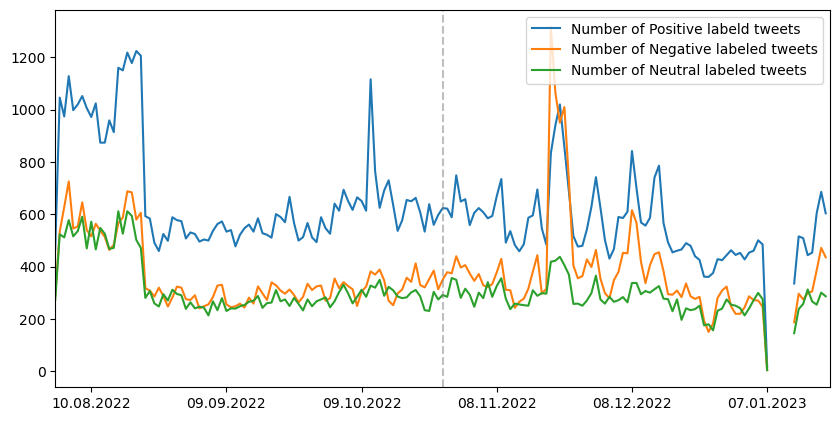

In [70]:
import matplotlib.dates as mdates


date_index = startdates_all

plt.figure(figsize=(10, 5), dpi=100)

plt.plot(date_index, positive_per_day, label='Number of Positive labeld tweets')
plt.plot(date_index, negative_per_day, label='Number of Negative labeled tweets')
plt.plot(date_index, neutral_per_day, label='Number of Neutral labeled tweets')

# set the tick locations and labels
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d.%m.%Y'))
plt.xlim(startdates_all[0], enddates_all[-1])

# Add a vertical line to mark the date of acquisition
plt.axvline(x=date_of_acquisition,color='gray',linestyle='--',alpha=0.5)

plt.legend(loc='upper right')
plt.show()

#### Compute the fractions of the positive, negative and netural off all tweets that days

In [53]:
positive_per_day_frac = np.zeros(len(startdates_all))
negative_per_day_frac = np.zeros(len(startdates_all))
neutral_per_day_frac  = np.zeros(len(startdates_all))
index = 0

for startdate, enddate in zip(startdates_all, enddates_all):
    df_temp = df_processed.loc[(df_processed['created_at'] >= startdate) & (df_processed['created_at'] < enddate)]
    if df_temp.size != 0:
        tweets_that_day = df_temp.shape[0]
        
        positive_count_of_day = df_temp.loc[df_temp['vader_label'] == 'Positive'].count()['vader_label']
        negative_count_of_day = df_temp.loc[df_temp['vader_label'] == 'Negative'].count()['vader_label']
        neutral_count_of_day = df_temp.loc[df_temp['vader_label'] == 'Neutral'].count()['vader_label']
        

        positive_per_day_frac[index] = positive_count_of_day/tweets_that_day
        negative_per_day_frac[index] = negative_count_of_day/tweets_that_day
        neutral_per_day_frac[index]  = neutral_count_of_day/tweets_that_day
        
    else:
        positive_per_day_frac[index] = np.nan
        negative_per_day_frac[index] = np.nan
        neutral_per_day_frac[index]  = np.nan
    
    index += 1


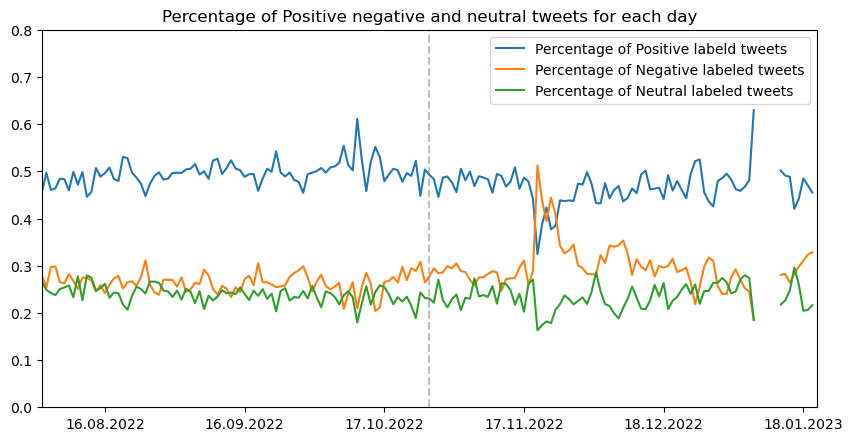

In [231]:
date_index = startdates_all

plt.figure(figsize=(10, 5), dpi=100)

plt.plot(date_index, positive_per_day_frac, label='Percentage of Positive labeld tweets')
plt.plot(date_index, negative_per_day_frac, label='Percentage of Negative labeled tweets')
plt.plot(date_index, neutral_per_day_frac, label='Percentage of Neutral labeled tweets')

# set the tick locations and labels
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=31))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d.%m.%Y'))
plt.xlim(startdates_all[0], enddates_all[-1])

# Add a vertical line to mark the date of acquisition
plt.axvline(x=date_of_acquisition,color='gray',linestyle='--',alpha=0.5)

plt.ylim(0,0.8)
plt.title("Percentage of Positive Negative and Neutral tweets for each day")

plt.legend(loc='upper right')
plt.show()

### Regression for the percentages of negtive tweets

In [141]:
# Linear Regression for trend in negative labeled tweets before and after acquisition

# Before Acquisition
x = np.arange(86)
neg_frac_before = negative_per_day_frac[:86]
neg_frac_after  = negative_per_day_frac[86:]

reg_before = LinearRegression().fit(x.reshape(-1,1), neg_frac_before)
coef_before = reg_before.coef_
intercept_before = reg_before.intercept_

regression_func_before = coef_before * x + intercept_before


In [150]:
# After Acquisition
neg_frac_after  = negative_per_day_frac[86:]
# Create an instance of the Imputer class
imputer = SimpleImputer(strategy='median')

# Fit the imputer on the X data
imputer.fit(neg_frac_after.reshape(-1, 1))

# Use the imputer to transform the X data
neg_frac_after = imputer.transform(neg_frac_after.reshape(-1, 1))

reg_after = LinearRegression().fit(x.reshape(-1,1), neg_frac_after)
coef_after = reg_after.coef_
intercept_after = reg_after.intercept_

regression_func_after = coef_after * x + intercept_after




In [160]:
# Whole Timespan
x_all = np.arange(len(startdates_all))
neg_frac_all  = negative_per_day_frac
# Create an instance of the Imputer class
imputer = SimpleImputer(strategy='median')

# Fit the imputer on the X data
imputer.fit(neg_frac_all.reshape(-1, 1))

# Use the imputer to transform the X data
neg_frac_all = imputer.transform(neg_frac_all.reshape(-1, 1))

reg_all = LinearRegression().fit(x_all.reshape(-1,1), neg_frac_all)
coef_all = reg_all.coef_
intercept_all = reg_all.intercept_

regression_func_all = coef_all * x_all + intercept_all

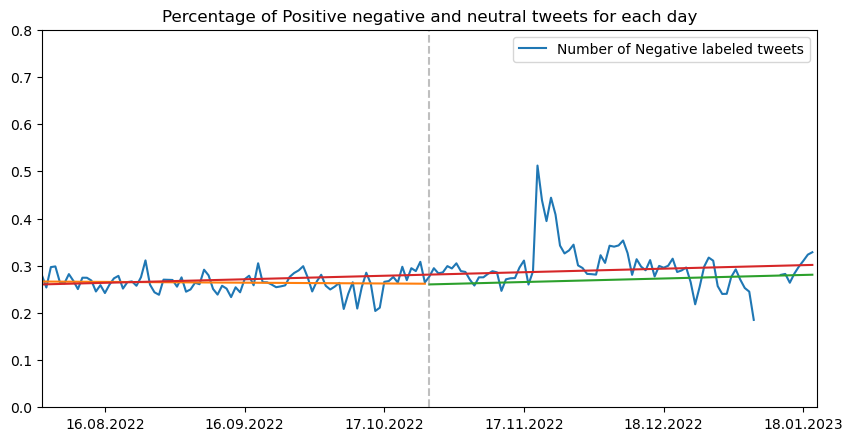

In [161]:
date_index = startdates_all

plt.figure(figsize=(10, 5), dpi=100)

plt.plot(date_index, negative_per_day_frac, label='Number of Negative labeled tweets')
plt.plot(date_index[:86], regression_func_before)
plt.plot(date_index[86:], regression_func_after[0])
plt.plot(date_index, regression_func_all[0])

# set the tick locations and labels
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=31))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d.%m.%Y'))
plt.xlim(startdates_all[0], enddates_all[-1])

# Add a vertical line to mark the date of acquisition
plt.axvline(x=date_of_acquisition,color='gray',linestyle='--',alpha=0.5)

plt.ylim(0,0.8)
plt.title("Percentage of Positive negative and neutral tweets for each day")

plt.legend(loc='upper right')
plt.show()

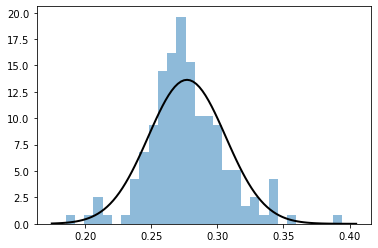

In [193]:
# Distribution of all values 
neg_frac_no_outliers = neg_frac_all[neg_frac_all <= 0.4]

plt.hist(neg_frac_no_outliers, bins = 30, density=True,alpha=0.5)

mu, std = norm.fit(neg_frac_no_outliers)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)



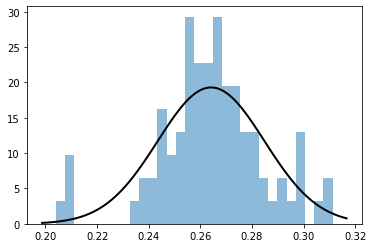

In [206]:
# Distribution of all values before
plt.hist(neg_frac_before, bins = 30, density=True,alpha=0.5)

mu, std = norm.fit(neg_frac_before)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)


In [207]:
shapiro(neg_frac_no_outliers_before)

ShapiroResult(statistic=0.9640319347381592, pvalue=0.017038436606526375)

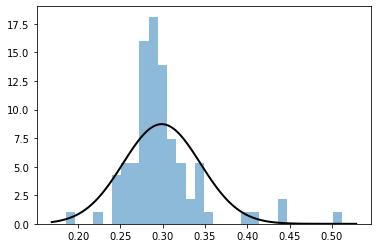

In [208]:
# Distribution of all after 
neg_frac_after

plt.hist(neg_frac_after, bins = 30, density=True,alpha=0.5)

mu, std = norm.fit(neg_frac_after)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)


In [209]:
# Perform the t-test
t_stat, p_val = ttest_ind(neg_frac_before, neg_frac_after)

# Print the results
print("t-statistic:", t_stat)
print("p-value:", p_val)

t-statistic: [-6.35646362]
p-value: [1.83146973e-09]


In [226]:
neg_frac_before = negative_per_day_frac[:86]
neg_frac_after  = negative_per_day_frac[86:]

stat, p_val = wilcoxon(neg_frac_before, neg_frac_after)

In [229]:
p_val

4.6760443877699875e-09

### KeyWording

In [264]:
transphoic_keywords = ['tranny', 'trannie', 'faggot', 'sissy', 'gaycure', 'exgay', 'traditionalmarriage', 'OnlyTwoGenders', 'Gay agend', 'gayagenda', 'homosexual agenda', 'homosexualagenda']

In [271]:
def tweet_contains_keywords(tweet):
    matches = [key for key in transphoic_keywords if key in tweet]
    return len(matches) > 0

In [278]:
df_keys = df_processed.loc[df_processed['text'].apply(tweet_contains_keywords)]

In [305]:
count_per_day = np.zeros(len(startdates_all))
index = 0

for startdate, enddate in zip(startdates_all, enddates_all):
    df_keys_temp = df_keys.loc[(df_keys['created_at'] >= startdate) & (df_keys['created_at'] < enddate)]
    if df_keys_temp.size != 0:
        count_per_day[index] = df_keys_temp.shape[0]
    else:
        count_per_day[index] = np.nan
    
    index += 1


In [307]:
count_per_day_original = count_per_day

In [308]:
# Clean the data and get rid of nan values

# Create an instance of the Imputer class
imputer = SimpleImputer(strategy='median')

# Fit the imputer on the X data
imputer.fit(count_per_day.reshape(-1, 1))

# Use the imputer to transform the X data
count_per_day = imputer.transform(count_per_day.reshape(-1, 1))

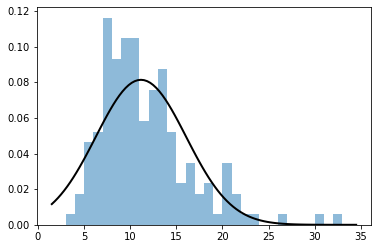

In [309]:
# Distribution of all values 
plt.hist(count_per_day, bins = 30, density=True,alpha=0.5)

mu, std = norm.fit(count_per_day)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)



In [318]:
count_per_day_before = count_per_day[:86]
count_per_day_after = count_per_day[86:]

In [319]:
# Perform the t-test
t_stat, p_val = ttest_ind(count_per_day_before, count_per_day_after)

# Print the results
print("t-statistic:", t_stat)
print("p-value:", p_val)

t-statistic: [1.41601217]
p-value: [0.15860153]


In [320]:
count_per_day_before = count_per_day_original[:86]
count_per_day_after = count_per_day_original[86:]

stat, p_val = wilcoxon(count_per_day_before, count_per_day_after)

# Print the results
print("Wilcoxon statistic:", stat)
print("Wilcoxon p-value:", p_val)

Wilcoxon statistic: 1333.0
Wilcoxon p-value: 0.12263043766752506


In [327]:
# Whole Timespan
x_all = np.arange(len(startdates_all))

reg_key = LinearRegression().fit(x_all.reshape(-1,1), count_per_day)
coef_key = reg_key.coef_
intercept_key = reg_key.intercept_

regression_func_key = coef_key * x_all + intercept_key

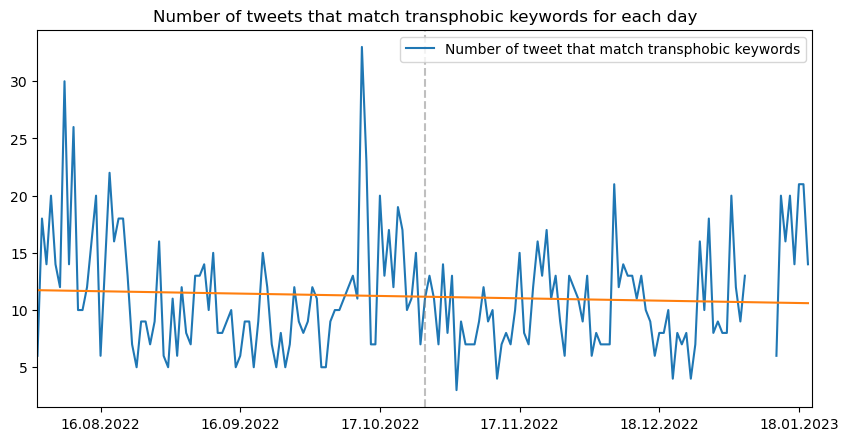

In [328]:
date_index = startdates_all

plt.figure(figsize=(10, 5), dpi=100)

plt.plot(date_index, count_per_day_original, label='Number of tweets that match transphobic keywords')
plt.plot(date_index, regression_func_all[0])

# set the tick locations and labels
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=31))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d.%m.%Y'))
plt.xlim(startdates_all[0], enddates_all[-1])

# Add a vertical line to mark the date of acquisition
plt.axvline(x=date_of_acquisition,color='gray',linestyle='--',alpha=0.5)

plt.title("Number of tweets that match transphobic keywords for each day")

plt.legend(loc='upper right')
plt.show()

### Hate Speach Detection

In [334]:
from transformers import pipeline

# Initialize the model
classifier = pipeline('text-classification', model='toxicity-model-base-cased')

# Classify the tweet
result = classifier("Stop the government, they are all aliens. Fuck them!")

# Print the result
print(result)

OSError: toxicity-model-base-cased is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo with `use_auth_token` or log in with `huggingface-cli login` and pass `use_auth_token=True`.

### <a name="wordcloud"></a> 6. Wordcloud

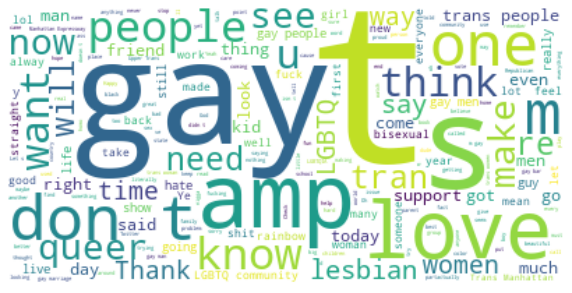

In [80]:
# Create a list of word
text= " ".join(tweets_text)

# Create a stopword list
stopwords = set(STOPWORDS)
stopwords.update(["http", "https", "co"])

# Create the wordcloud object
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
 
# Display the generated image (matplotlib way):
plt.figure(figsize = (10, 15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()